# Project: Image Blending

## Author:  SUMIT KUTTY

### Load necessary packages

In [2155]:
import cv2
import imutils
import os
import numpy as np
import matplotlib.pyplot as plt
import time

## Functions

In [2156]:
def load_image(path, flag = None):
    '''
    #Loads and converts image to RGB.
    '''
    img = cv2.imread(path, flag)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def process_image(img):
    '''
    Processes the image to ease the foreground extraction.
    * thresholding
    * smoothening
    * edge detection
    * contour extraction
    
    RETURNS: Pre-Processed Image, Contour Coordinates.
    '''
    #to make the inner knife and outer a part of same
    ret, thresh = cv2.threshold(img, 251, 255, cv2.THRESH_BINARY) 
    #to add noise such that the edges are smoother
    blurred = cv2.GaussianBlur(thresh, (7,7), 0) 
    #canny requires grayscale
    gray = cv2.cvtColor(blurred, cv2.COLOR_RGB2GRAY) 
    #Edge detection based on thresholds (500, 200)
    edges = cv2.Canny(gray, 490, 200) 

    
    #Smoothening little more
    blur = cv2.GaussianBlur(edges, (1,1), 0)
    #Finding Contours
    contours, hierarchy = cv2.findContours(blur, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    return blur, contours #processed image and contours


def viz_images(img1, img2):
    '''
    Visualize two images side by side.
    '''
    fig , (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(10,12))
    ax1.imshow(img1)
    ax2.imshow(img2, cmap = 'gray')
    plt.show()
    
    
def show(img, title, cnt=None):
    '''
    * Displays an Image
    * Draws contour
    '''
    if cnt is None:
        plt.figure(figsize = (10,12))
        plt.title(title, fontsize = 12)
        plt.imshow(img)
        plt.show()
            
    else: #If contour is sent
        c = cv2.drawContours(img, cnt, -1, (0,255,0), 1)
        plt.figure(figsize = (10,12))
        plt.title("Contour")
        plt.imshow(c)
        plt.show()
        
        
def write_image(img, path, names):
    '''
    Writes Image to disk
    '''
    for i in names:
        cv2.imwrite(f"{path}{i}.png", img)
        
        
def convert_to_png(img):
    '''
    Adds alpha channel
    '''
    tmp = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _,alpha = cv2.threshold(tmp,0,255,cv2.THRESH_BINARY)
    b, g, r, a = cv2.split(img)
    rgba = [b,g,r, alpha]
    dst = cv2.merge(rgba,4)
    return dst


def scalenrotate(dst): 
    '''
    Scales down by a factor and rotates 45 degrees
    '''
    width_resize = int(dst.shape[1] * 0.4)
    dst = imutils.resize(dst, width = width_resize)
    
    #Rotate and Keep the image within the frame
    rotated = imutils.rotate_bound(dst, 45)
    
    return rotated

        

## Function to Extract Foreground

In [2157]:
def extract_foreground(img, proc_img, contour, path):
    '''
    Adding mask to the contour
    Extracting the ROI from the original threat image.
    Adding alpha channel and making background transparent.
    Scaling and Rotating the threat object by 45 deg
    
    RETURNS: Extracted Threat Object
    '''
    
    image_contour = np.copy(img)

    mask = np.zeros_like(proc_img) #create a image with zeros with the same structure

    cv2.fillPoly(mask, [contour], 255) #Mask the Contour Area using 'White'

    res_mask = np.copy(mask)

    #ASsign flags to Foreground object pixels
    res_mask[mask == 0] = cv2.GC_BGD
    res_mask[mask == 255] = cv2.GC_PR_BGD
    res_mask[mask == 255] = cv2.GC_FGD


    #Filter pixels where Flags are true
    mask2 = np.where( 
                (res_mask == cv2.GC_PR_FGD) | (res_mask == cv2.GC_FGD), 255, 0
                 
                 ).astype('uint8')
    

    foreground = np.copy(img)
    
    foreground[mask2==0] = 0

    #scale and rotate
    foreground = scalenrotate(foreground)
    
    #Add alpha channel and convert to PNG (make alpha = 0)
    foreground = cv2.cvtColor(foreground, cv2.COLOR_RGB2BGRA)
    foreground = convert_to_png(foreground)

    #write to disk
    write_image(foreground, path, ['fg'])
    
    return foreground 



## Apply the Threat Object to Background

In [2158]:
def add_to_background(bgpath,fgpath):
    '''
    Load images using Pillow function
    Using the blend and paste functions to paste the threat object on the baggage image.
    
    returns: Final BLended Image
    '''
    bg = Image.open(bgpath)
    fg = Image.open(fgpath)
    
    #Blending
    alpha = 0.8
    loc = (10,20)
    fg_img_trans = Image.new("RGBA",fg.size)
    fg_img_trans = Image.blend(fg_img_trans,fg,alpha)
    bg.paste(fg_img_trans,box,fg_img_trans)
    
    return bg
    

### Path Declaration and Image name

In [2159]:
bg_imgs = os.listdir('background_images')
threat_imgs = os.listdir('threat_images')

bgimg = 'BAGGAGE_20180811_175323_83216_B_1.jpg'
threatimg = 'BAGGAGE_20170522_113049_80428_A.jpg'

fgimg = '45deg.png'
fgpath = 'threat_masks/' + fgimg


bgpath =     'background_images/' + bgimg
threatpath = 'threat_images/' + threatimg

fgp = 'threat_masks/'

output_path = 'final_output/'


## Main

FOREGROUND IMAGE


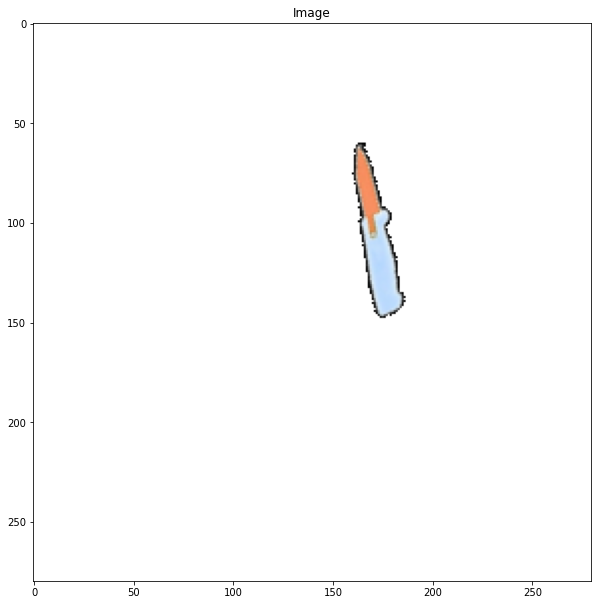

FINAL IMAGE


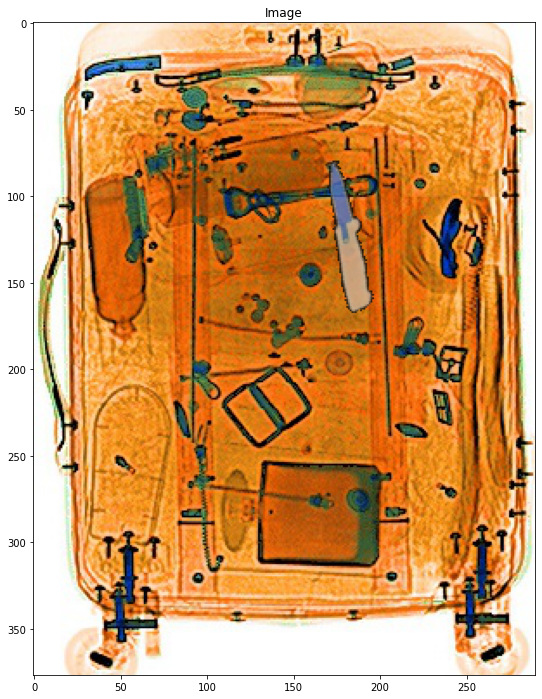

In [2160]:

img = load_image(threatpath)
bg= load_image(bgpath)

proc_img, cnts = process_image(img)

contour = max(cnts, key = cv2.contourArea)

fg = extract_foreground(img, proc_img, contour, fgp)
show(fg, "THREAT OBJECT")


final_img = add_to_background(bgpath, fgpath)
show(final_img, "FINAL IMAGE")


In [2161]:
#final_img.save(output_path+'result1_2.jpg')

# THE END